In [1]:
!pip install librosa pandas numpy rich

In [2]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from rich.console import Console

console = Console()

## **Donwload Data**

This dataset was used for the well known paper in genre classification "Musical genre classification of audio signals" by G. Tzanetakis and P. Cook in IEEE Transactions on Audio and Speech Processing 2002.

https://www.kaggle.com/datasets/carlthome/gtzan-genre-collection

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carlthome/gtzan-genre-collection")

console.print("Path to dataset files:", path)

100%|██████████| 1.14G/1.14G [00:15<00:00, 80.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/carlthome/gtzan-genre-collection/versions/1

In [4]:
!ls {path}/genres/country

country.00000.au  country.00025.au  country.00050.au  country.00075.au
country.00001.au  country.00026.au  country.00051.au  country.00076.au
country.00002.au  country.00027.au  country.00052.au  country.00077.au
country.00003.au  country.00028.au  country.00053.au  country.00078.au
country.00004.au  country.00029.au  country.00054.au  country.00079.au
country.00005.au  country.00030.au  country.00055.au  country.00080.au
country.00006.au  country.00031.au  country.00056.au  country.00081.au
country.00007.au  country.00032.au  country.00057.au  country.00082.au
country.00008.au  country.00033.au  country.00058.au  country.00083.au
country.00009.au  country.00034.au  country.00059.au  country.00084.au
country.00010.au  country.00035.au  country.00060.au  country.00085.au
country.00011.au  country.00036.au  country.00061.au  country.00086.au
country.00012.au  country.00037.au  country.00062.au  country.00087.au
country.00013.au  country.00038.au  country.00063.au  country.00088.au
countr

## **Data Visualization**

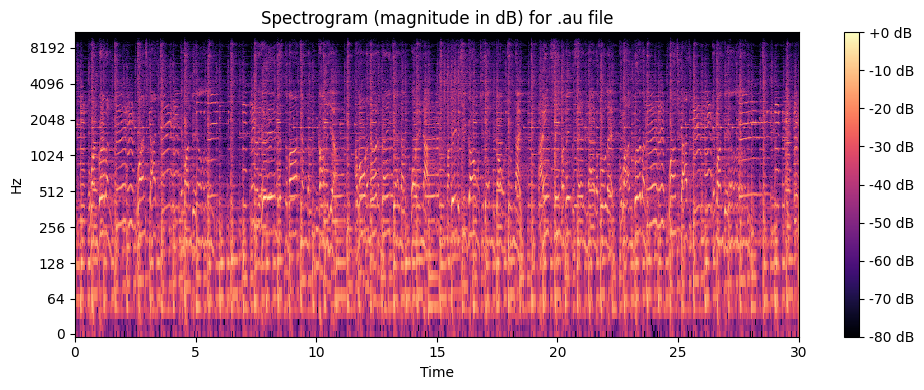

Shape of the matrix S_magnitude (frequencies x time): (1025, 1293)

Number of frequency bands (p): 1025

In [20]:
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512

audio_file = f'{path}/genres/blues/blues.00000.au'

try:
    audio_time_series, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
except Exception as e:
    console.print(f"Error loading the file: {e}. Verify the path")

# S(f, t)
S_complex = librosa.stft(audio_time_series, n_fft=N_FFT, hop_length=HOP_LENGTH)

# magnitude for each frequency and time
S_magnitude = np.abs(S_complex)

# Visualization
S_db = librosa.amplitude_to_db(S_magnitude, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db,
                         sr=sample_rate,
                         hop_length=HOP_LENGTH,
                         x_axis='time',
                         y_axis='log')

plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (magnitude in dB) for .au file')
plt.tight_layout()
plt.show() #

console.print(f"\nShape of the matrix S_magnitude (frequencies x time): {S_magnitude.shape}")
p_bands = S_magnitude.shape[0]
console.print(f"Number of frequency bands (p): {p_bands}")

## **Function to obtain a feature vector from the complex matrix S(f, T)**

- The signal is loaded using the librosa library
- Time-Frequency Analysis (SFTT) is performed, obtaining S(f, t)
- The magnitude is calculated
- The audio feature vector is constructed by averaging the magnitude over time

In [23]:
def extract_spectral_features(audio_path, n_fft=N_FFT, sr=SAMPLE_RATE):
    try:
        # 1. Signal loading
        # Solely 30s for GTZAN
        y, _ = librosa.load(audio_path, sr=sr, duration=30)

        # 2. Time-Frequency Analysis (STFT)
        # S_complex: Matrix S(f, t)
        S_complex = librosa.stft(y, n_fft=n_fft, hop_length=HOP_LENGTH)

        # 3. Magnited is calculated
        S_magnitude = np.abs(S_complex)

        # 4. Feature Vector is built by averaging the magnitude over time
        mean_spectrum_vector = np.mean(S_magnitude, axis=1)

        return mean_spectrum_vector
    except Exception as e:
        print(f"Error file processing  {os.path.basename(audio_path)}: {e}")
        return None

## **Construction of the data matrix X(n x p) from the extraction of all the audios from the different categories**

In [27]:
from tqdm import tqdm

BASE_DIR = f'{path}/genres'

file_paths = []
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

for genre in genres:
    genre_path = os.path.join(BASE_DIR, genre)
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.au'):
                file_paths.append(os.path.join(genre_path, filename))

feature_vectors = []
labels = []

console.print(f"Starting extraction for {len(file_paths)} files...")

for audio_path in tqdm(file_paths, desc="Extracting"):
    features = extract_spectral_features(audio_path)

    if features is not None:
        feature_vectors.append(features)
        labels.append(os.path.basename(os.path.dirname(audio_path)))

# Build matrix X (n x p)
# n = observations number (audio segments)
# p = frequency band number
if feature_vectors:
    X_matrix = np.vstack(feature_vectors)

    # frequency band number
    p_vars = X_matrix.shape[1]

    # Create Dataframe X (n x p)
    column_names = [f'Freq_Band_{i}' for i in range(p_vars)]
    X_df = pd.DataFrame(X_matrix, columns=column_names)

    X_df['Genre'] = labels

    console.print("\n" + "="*50)
    console.print("CONSTRUCTED MULTIVARIABLE DATA MATRIX (X)")
    console.print("="*50)
    console.print(f"X (n x p) Shape: {X_matrix.shape}")
    console.print(f"n = observations number (audio segments): {X_matrix.shape[0]}")
    console.print(f"p = frequency band number: {X_matrix.shape[1]}")
    display(X_df.head())
else:
    console.print("\nERROR........")

Starting extraction for 1000 files...

Extracting: 100%|██████████| 1000/1000 [00:41<00:00, 24.21it/s]


==================================================

CONSTRUCTED MULTIVARIABLE DATA MATRIX (X)

==================================================

X (n x p) Shape: (1000, 1025)

n = observations number (audio segments): 1000

p = frequency band number: 1025

,Freq_Band_0,Freq_Band_1,Freq_Band_2,Freq_Band_3,Freq_Band_4,Freq_Band_5,Freq_Band_6,Freq_Band_7,Freq_Band_8,Freq_Band_9,...,Freq_Band_1016,Freq_Band_1017,Freq_Band_1018,Freq_Band_1019,Freq_Band_1020,Freq_Band_1021,Freq_Band_1022,Freq_Band_1023,Freq_Band_1024,Genre
0,18.117540,9.114561,2.207157,6.513214,14.779707,30.582630,38.063236,42.542877,40.904835,20.866613,...,0.006484,0.006492,0.006492,0.006485,0.006485,0.006487,0.006493,0.006487,0.006465,blues
1,1.663813,4.989823,6.715083,7.513004,13.706044,21.548460,25.891663,25.346096,20.641577,18.581114,...,0.000369,0.000367,0.000365,0.000359,0.000362,0.000362,0.000363,0.000348,0.000323,blues
2,0.974456,1.900612,8.628450,21.395824,27.733854,25.963226,26.462643,26.681301,27.560408,22.697733,...,0.000247,0.000252,0.000246,0.000240,0.000238,0.000242,0.000239,0.000240,0.000219,blues
3,0.956346,1.846664,2.424577,2.652958,2.407018,3.930319,4.201232,3.152735,2.712455,2.802366,...,0.000253,0.000251,0.000251,0.000250,0.000245,0.000244,0.000245,0.000243,0.000228,blues
4,1.780294,1.871975,2.591125,5.421940,11.337670,17.570971,31.278965,52.000103,49.842789,40.120205,...,0.000292,0.000288,0.000280,0.000283,0.000282,0.000283,0.000286,0.000291,0.000265,blues


## **Standardization of variables**

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_matrix)

## **Calculating PCA**

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_standardized)

In [31]:
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

console.print("Principal Component Calculation Results:")
console.print(f"Scores Matrix Shape (X_pca): {X_pca.shape}")
console.print(f"Number of Eigenvalues (variances): {eigenvalues.shape[0]}")
console.print(f"Eigenvector Matrix Shape (Loadings, p x p): {eigenvectors.shape}")

console.print("\nProportion of Variance Explained by the first 5 Components:")
for i in range(5):
    console.print(f"PC {i+1}: {explained_variance_ratio[i]*100:.2f}%")

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

console.print(f"\nCumulative Variance after PC 2: {cumulative_variance_ratio[1]*100:.2f}%")
console.print(f"Cumulative Variance after PC 10: {cumulative_variance_ratio[9]*100:.2f}%")

Principal Component Calculation Results:

Scores Matrix Shape (X_pca): (1000, 1000)

Number of Eigenvalues (variances): 1000

Eigenvector Matrix Shape (Loadings, p x p): (1000, 1025)

Proportion of Variance Explained by the first 5 Components:

PC 1: 66.02%

PC 2: 13.86%

PC 3: 3.75%

PC 4: 1.70%

PC 5: 1.54%

Cumulative Variance after PC 2: 79.88%

Cumulative Variance after PC 10: 90.61%

## **Explained Variance**

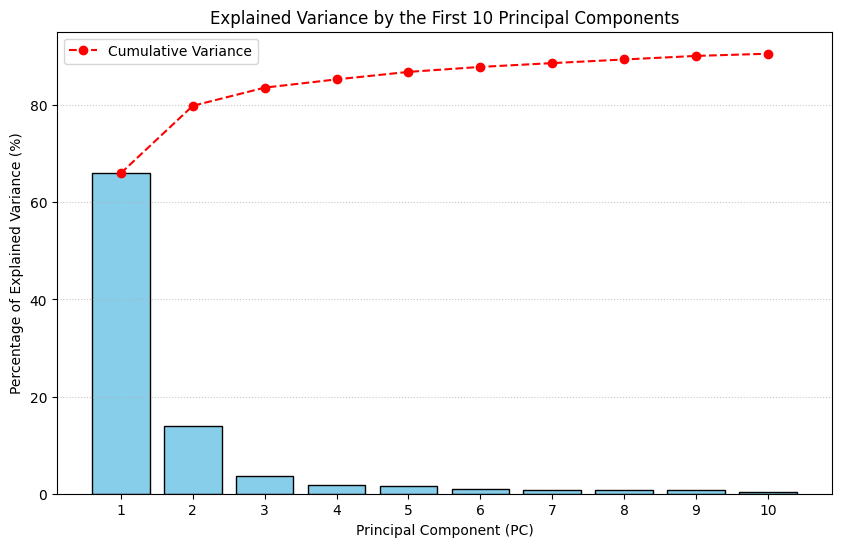

In [33]:
num_components_to_plot = 10
variances_to_plot = explained_variance_ratio[:num_components_to_plot] * 100

plt.figure(figsize=(10, 6))

plt.bar(range(1, num_components_to_plot + 1),
        variances_to_plot,
        color='skyblue', edgecolor='black')

plt.plot(range(1, num_components_to_plot + 1),
         cumulative_variance_ratio[:num_components_to_plot] * 100,
         marker='o', linestyle='--', color='red', label='Cumulative Variance')


plt.title(f'Explained Variance by the First {num_components_to_plot} Principal Components')
plt.xlabel('Principal Component (PC)')
plt.ylabel('Percentage of Explained Variance (%)')
plt.xticks(range(1, num_components_to_plot + 1))
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.legend()
plt.show()

## **Loadings**

In [58]:
eigenvectors = pca.components_

column_names = [f'Freq_Band_{i}' for i in range(eigenvectors.shape[1])]

loadings = pd.DataFrame(eigenvectors.T,
                        columns=[f'PC{i+1}' for i in range(eigenvectors.shape[0])],
                        index=column_names)

console.print("\nLoadings:")
loadings

Loadings:

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC991,PC992,PC993,PC994,PC995,PC996,PC997,PC998,PC999,PC1000
Freq_Band_0,0.003935,-0.006709,-0.003522,0.004704,0.012722,-0.011096,0.005303,-0.002847,0.036075,0.026941,...,-0.001727,0.000192,0.002086,-0.000794,0.001394,0.000319,-0.001954,0.000121,0.002040,-0.001283
Freq_Band_1,0.008737,-0.003628,0.002879,0.017505,-0.001265,-0.013289,0.001795,-0.026424,0.043277,0.020485,...,0.002045,0.000280,-0.002742,0.000581,-0.001723,0.000055,0.002225,-0.000679,-0.002251,0.001954
Freq_Band_2,0.015793,0.001631,0.009994,0.036324,-0.042958,-0.005450,0.023546,-0.043405,0.019855,-0.006624,...,-0.003416,0.001496,0.005524,-0.001081,0.003412,-0.000109,-0.002548,0.003006,0.002695,-0.004864
Freq_Band_3,0.019836,0.007652,0.008937,0.048402,-0.058820,-0.008205,0.030801,-0.031780,0.019440,0.028398,...,0.008025,-0.004722,-0.012579,0.001555,-0.008009,0.003350,0.000610,-0.007292,-0.006592,0.010678
Freq_Band_4,0.021846,0.008885,0.007470,0.054496,-0.060202,-0.015043,0.030230,-0.022025,0.009026,0.055029,...,-0.006809,0.000899,0.016052,0.004410,0.015268,-0.004487,0.005423,0.012481,0.006591,-0.020034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Freq_Band_1020,0.026631,0.055287,0.024158,-0.015619,-0.037283,0.010876,-0.007602,0.001411,0.009634,0.019241,...,0.040336,-0.094845,0.025181,-0.007929,0.026482,0.016584,-0.009593,0.009554,0.067044,-0.107650
Freq_Band_1021,0.027019,0.055784,0.015524,-0.033592,-0.002106,0.022268,-0.001496,-0.008277,0.009364,0.014580,...,-0.019152,0.017991,-0.079691,-0.001063,-0.004389,0.038387,0.004742,0.041128,0.015020,0.029973
Freq_Band_1022,0.026904,0.055576,0.021583,-0.023603,-0.022208,0.016628,-0.005155,-0.002858,0.008379,0.020563,...,0.007371,-0.014852,0.117293,-0.042022,-0.028721,-0.048495,-0.031033,-0.053980,-0.055113,0.094239
Freq_Band_1023,0.026865,0.055212,0.013384,-0.040125,0.008952,0.024549,-0.001543,-0.012784,0.008957,0.016821,...,-0.057861,0.009132,-0.080099,0.038802,0.155098,0.065820,0.016657,0.031979,0.057782,-0.111275


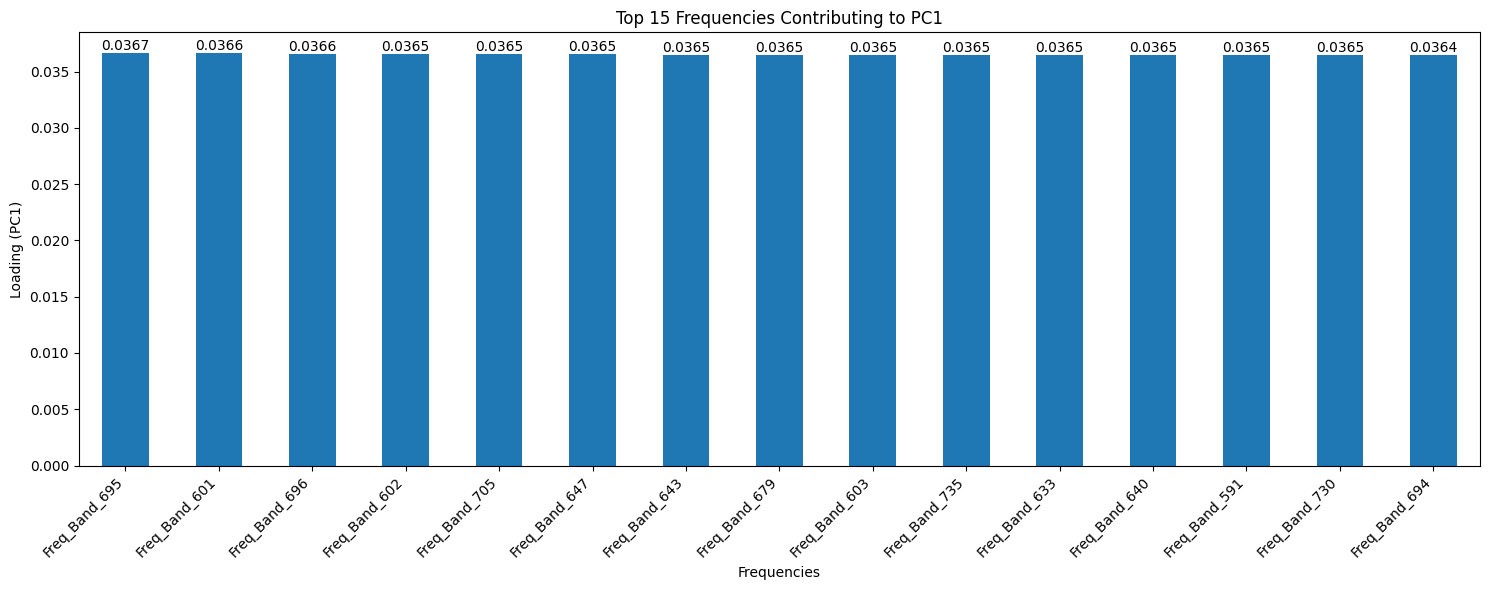

In [64]:
plt.figure(figsize=(15, 6))
ax = loadings.reindex(loadings['PC1'].abs().sort_values(ascending=False).index).iloc[:15, 0].plot(kind='bar')
plt.title('Top 15 Frequencies Contributing to PC1')
plt.xlabel('Frequencies')
plt.ylabel('Loading (PC1)')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')


plt.tight_layout()
plt.show()

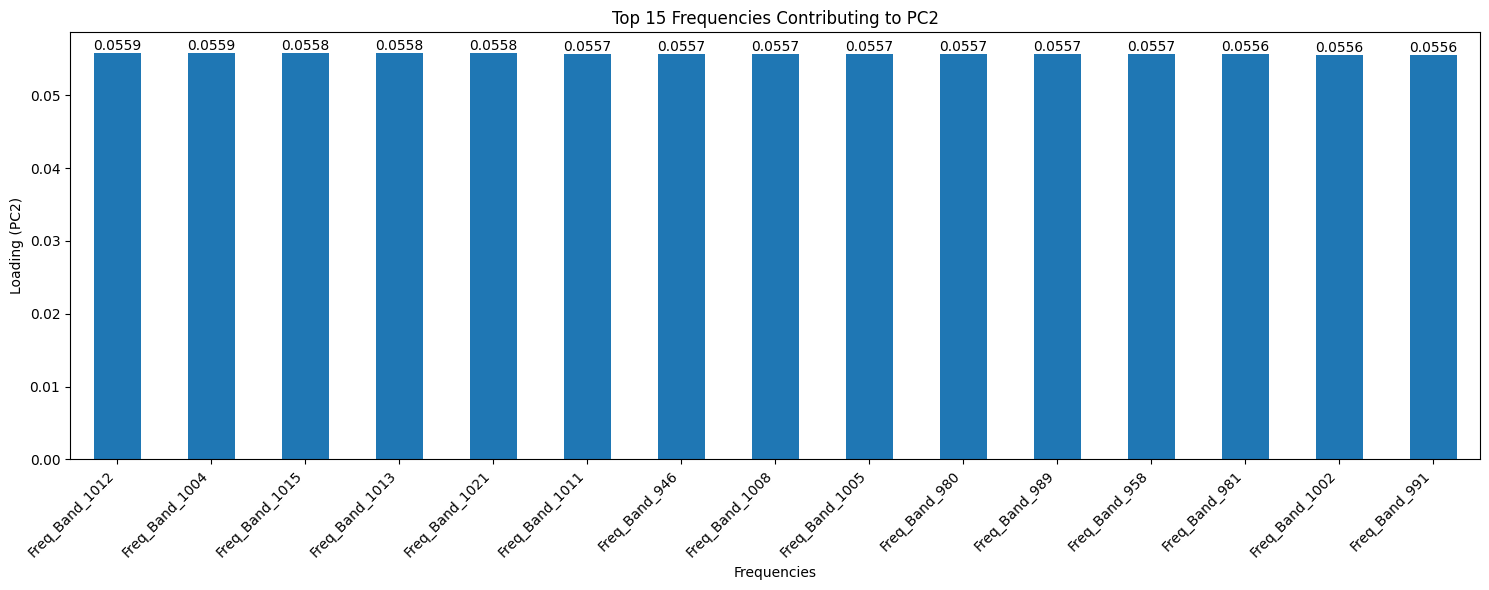

In [60]:
plt.figure(figsize=(15, 6))
ax = loadings.reindex(loadings['PC2'].abs().sort_values(ascending=False).index).iloc[:15, 1].plot(kind='bar')
plt.title('Top 15 Frequencies Contributing to PC2')
plt.xlabel('Frequencies')
plt.ylabel('Loading (PC2)')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')


plt.tight_layout()
plt.show()

## **Component Visualization**

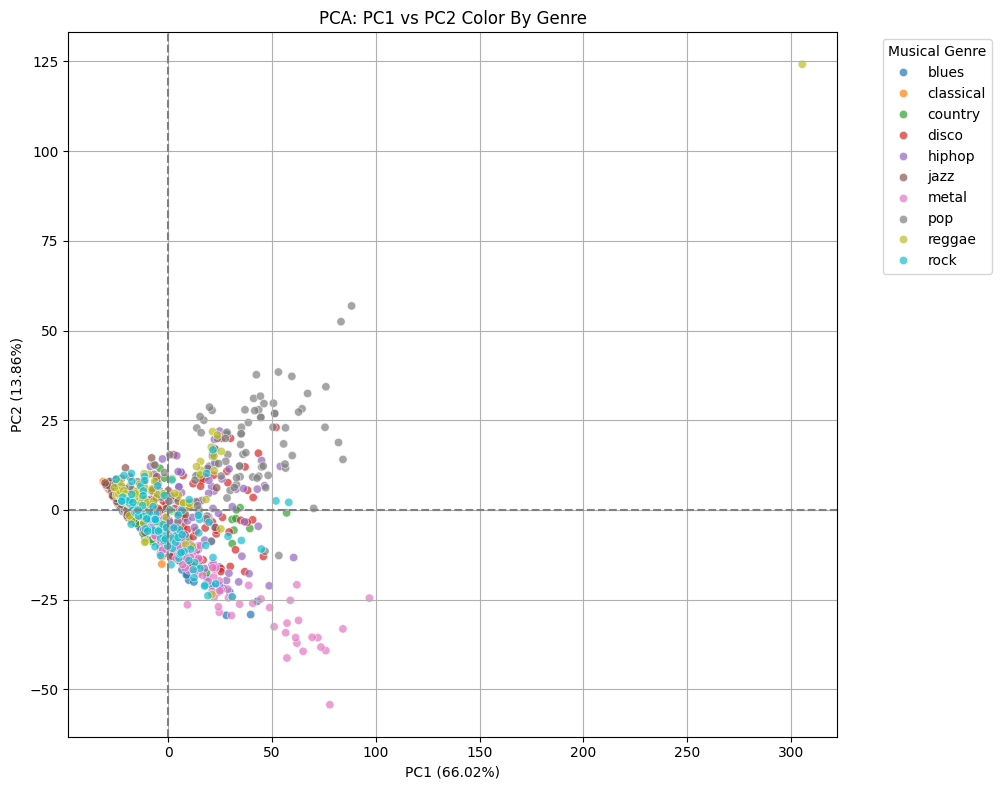

In [61]:
import seaborn as sns

scores_df = pd.DataFrame(X_pca, columns=[f'CP{i+1}' for i in range(X_pca.shape[1])])

scores_df['Genre'] = labels

plt.figure(figsize=(12, 8))
sns.scatterplot(x='CP1', y='CP2', hue='Genre', data=scores_df, alpha=0.7)

plt.title('PCA: PC1 vs PC2 Color By Genre')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

plt.legend(title="Musical Genre", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [62]:
import plotly.express as px

scores_df = pd.DataFrame(X_pca, columns=[f'CP{i+1}' for i in range(X_pca.shape[1])])

scores_df['Genre'] = labels

fig = px.scatter_3d(
    scores_df,
    x='CP1',
    y='CP2',
    z='CP3',
    color='Genre',
    title='PCA: PC1 vs PC2 vs PC3 colored by Musical Genre',
    labels={'CP1': f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', 'CP2': f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', 'CP3': f'PC3 ({pca.explained_variance_ratio_[2]:.2%})'},
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig.show()

## Conclusions from the PCA Analysis

Based on the Principal Component Analysis performed on the spectral features of the audio data, we can draw the following conclusions:

* The first component accounts for 66% of the explained variance.
The first three components already account for approximately 82% of the explained variance, demonstrating that the 1025 frequencies are highly balanced.

* It also tells us that the frequencies have a high loading for each component, that is, they contribute a lot to the explained variance of each component.

* We can observe for example that the first 15 frequencies have equal charges.

* We can also see the same behavior of the loads for the second component.

* Regarding the division of genres into two main components, it can be observed that genres such as blues, classical, country, and jazz are very similar, so they are closely grouped together; on the other hand, music such as metal and pop are very distinct from the others.

Overall, the PCA analysis demonstrates that the spectral features of the audio data are informative for understanding the underlying structure and variability in the dataset and that a reduced set of principal components can effectively represent these features for further analysis or modeling.